In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import Timestamp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:

START_DATE = '2023-01-01'
END_DATE = '2024-12-31'
INITIAL_CAPITAL = 100000000

# Parâmetros VWAP
VWAP_PERIOD = 20
STOP_LOSS = 0.03
TAKE_PROFIT = 0.06
MAX_POSITIONS = 5
# CDI médio anual (% ao ano) - ajuste conforme período
CDI_RATE_YEARLY = 0.1175  # 11.75% a.a. (média 2023-2024)

In [3]:
# Calcular VWAP rolling
def calcular_vwap_rolling(group):
    group['PV'] = group['Preco_Tipico'] * group['Volume']
    group['VWAP'] = (
        group['PV'].rolling(window=20, min_periods=1).sum() /
        group['Volume'].rolling(window=20, min_periods=1).sum()
    )
    return group

In [4]:
def df_to_dict(df):
    """
    Converte DataFrame consolidado em dicionário por ativo
    """
    data = {}

    for ativo in df['Ativo'].unique():
        # Filtrar dados do ativo
        df_ativo = df[df['Ativo'] == ativo].copy()

        # Remover coluna Ativo
        df_ativo = df_ativo.drop(columns=['Ativo'])

        # Definir Data como index
        df_ativo = df_ativo.set_index('Data')

        # Adicionar ao dicionário
        data[ativo] = df_ativo

    return data

In [5]:
def download_data():
    df = pd.read_excel('./base.xlsx')
    df.replace('-', '', inplace=True)
    df['High'] = pd.to_numeric(df['High'])
    df['Low'] = pd.to_numeric(df['Low'])
    df['Close'] = pd.to_numeric(df['Close'])
    df['Volume'] = pd.to_numeric(df['Volume'])

    df = df.sort_values(['Ativo', 'Data'])

    # Calcular o Volume Médio de 20 dias por ativo
    df['Vol_MA'] = df.groupby('Ativo')['Volume'].transform(
        lambda x: x.rolling(window=20, min_periods=1).mean()
    )

    df['Preco_Tipico'] = (df['High'] + df['Low'] + df['Close']) / 3

    df = df.groupby('Ativo', group_keys=False).apply(calcular_vwap_rolling)

    # Remover colunas auxiliares
    df = df.drop(columns=['Preco_Tipico', 'PV'])

    df = df.dropna()

    data = df_to_dict(df)
    return data

In [6]:
def backtest_vwap(data, capital):
    """Estratégia VWAP com stop/target + posições LONG e SHORT"""

    cash = capital
    positions = {}
    trades = []
    equity = []

    all_dates = sorted(set(d for df in data.values() for d in df.index))

    print("🔵 ESTRATÉGIA VWAP (LONG + SHORT)")
    print(f"   Período: {all_dates[0].date()} até {all_dates[-1].date()}")
    print(f"   Regras LONG: Preço acima VWAP + Volume alto")
    print(f"   Regras SHORT: Preço abaixo VWAP + Volume alto")
    print(f"   Saída: Stop/Target ou reversão VWAP\n")

    for date in all_dates:
        for sym in list(positions.keys()):
            if sym not in data or date not in data[sym].index:
                continue

            price = float(data[sym].loc[date, 'Close'])
            vwap = float(data[sym].loc[date, 'VWAP'])
            pos = positions[sym]
            ptype = pos.get('type', 'long')

            # Retorno relativo
            if ptype == 'long':
                ret = (price - pos['entry']) / pos['entry']
            else:  # short
                ret = (pos['entry'] - price) / pos['entry']

            # Verifica saída
            should_exit = False
            reason = ''

            if ptype == 'long':

                if ret <= -STOP_LOSS:
                    should_exit = True
                    reason = 'Stop Loss'
                elif ret >= TAKE_PROFIT:
                    should_exit = True
                    reason = 'Take Profit'
                elif price < vwap:
                    should_exit = True
                    reason = 'Below VWAP'

            else:  # short

                if ret <= -STOP_LOSS:
                    should_exit = True
                    reason = 'Stop Loss (Short)'
                elif ret >= TAKE_PROFIT:
                    should_exit = True
                    reason = 'Take Profit (Short)'
                elif price > vwap:
                    should_exit = True
                    reason = 'Above VWAP (Short)'

            # Se realizar saída
            if should_exit:
                proceeds = pos['shares'] * price

                if ptype == 'long':
                    pnl = proceeds - pos['cost']        # venda - compra
                    cash += proceeds
                else:
                    pnl = pos['cost'] - proceeds        # venda inicial - recompra
                    cash += pos['cost']                 # devolve a "margem" do short

                trades.append({
                    'Symbol': sym,
                    'Entry': pos['date'],
                    'Exit': date,
                    'Entry_Price': pos['entry'],
                    'Exit_Price': price,
                    'Type': ptype,
                    'PnL': pnl,
                    'PnL_%': (pnl / pos['cost']) * 100,
                    'Reason': reason
                })

                del positions[sym]

        # ============================================================
        # BUSCA ENTRADAS (SINAIS)
        # ============================================================

        if len(positions) < MAX_POSITIONS:
            signals = []

            for sym, df in data.items():
                if sym in positions or date not in df.index:
                    continue

                price = float(df.loc[date, 'Close'])
                vwap = float(df.loc[date, 'VWAP'])
                vol = float(df.loc[date, 'Volume'])
                vol_ma = float(df.loc[date, 'Vol_MA'])

                # ------- SINAL LONG -------
                if price > vwap and vol > vol_ma * 1.2:
                    dist = (price - vwap) / vwap
                    score = (vol / vol_ma) * (1 + dist)
                    signals.append((sym, price, score, 'long'))

                # ------- SINAL SHORT -------
                if price < vwap and vol > vol_ma * 1.2:
                    dist = (vwap - price) / vwap
                    score = (vol / vol_ma) * (1 + dist)
                    signals.append((sym, price, score, 'short'))

            # Ordena por score (mais forte primeiro)
            signals.sort(key=lambda x: x[2], reverse=True)

            # Abre posições
            for sym, price, _, sig_type in signals[:MAX_POSITIONS - len(positions)]:
                pos_size = cash * 0.20
                shares = int(pos_size / price)

                if shares > 0:
                    cost = shares * price

                    if sig_type == 'long':
                        buy_fee = cost * 0.001     # 0.1% custo de compra
                        total_cost = cost + buy_fee

                        if total_cost <= cash:
                            cash -= total_cost

                        positions[sym] = {
                            'shares': shares,
                            'entry': price,
                            'date': date,
                            'cost': total_cost,     # custo inclui taxa
                            'type': sig_type
                        }

                    else:  # SHORT
                        borrow_fee = cost * 0.01   # 1% aluguel
                        total_margin = cost + borrow_fee

                        if total_margin <= cash:
                            cash -= total_margin

                        positions[sym] = {
                            'shares': shares,
                            'entry': price,
                            'date': date,
                            'cost': total_margin,   # custo inclui aluguel
                            'type': sig_type
                        }


        # ============================================================
        # EQUITY
        # ============================================================

        pos_val = 0
        for s, p in positions.items():
            if s in data and date in data[s].index:
                price = float(data[s].loc[date, 'Close'])
                if p['type'] == 'long':
                    pos_val += p['shares'] * price
                else:
                    # short: valor é entrada - (preço atual * shares)
                    pos_val += (p['entry'] - price) * p['shares'] + p['cost']

        equity.append({
            'Date': date,
            'Equity': cash + pos_val
        })

    # ============================================================
    # FECHA POSIÇÕES NO FINAL
    # ============================================================

    if all_dates:
        last = all_dates[-1]

        for sym in list(positions.keys()):
            if sym in data and last in data[sym].index:
                pos = positions[sym]
                price = float(data[sym].loc[last, 'Close'])
                ptype = pos['type']

                proceeds = pos['shares'] * price

                if ptype == 'long':
                    pnl = proceeds - pos['cost']
                    cash += proceeds
                else:
                    pnl = pos['cost'] - proceeds
                    cash += pos['cost']

                trades.append({
                    'Symbol': sym,
                    'Entry': pos['date'],
                    'Exit': last,
                    'Entry_Price': pos['entry'],
                    'Exit_Price': price,
                    'Type': ptype,
                    'PnL': pnl,
                    'PnL_%': (pnl / pos['cost']) * 100,
                    'Reason': 'End'
                })

    return pd.DataFrame(trades), pd.DataFrame(equity)

In [7]:
def backtest_cdi(all_dates, capital):
    """CDI - Rendimento de renda fixa"""
    
    # Certifica que df_di está com índice por data para lookup rápido
    df_di = pd.read_excel('./di_rates.xlsx')
    df_di = df_di.set_index('Data')

    print("🟡 BENCHMARK: CDI real")
    current_capital = capital*((1 + (df_di['DI_Rate'][0] / 100))**(1/252))
    equity = [{
            'Date': Timestamp('2023-01-01 00:00:00'),
            'Equity': current_capital,
            'DI_daily': (1 + (df_di['DI_Rate'][0] / 100))**(1/252) - 1
        }]

    for date in all_dates:
        if date in df_di.index:
            di_daily = df_di.loc[date, 'DI_Rate']
        else:
            # Se não tiver dado para esse dia (ex: fim de semana), você pode pular
            # Ou reusar a última taxa conhecida:
            di_daily = df_di.loc[df_di.index <= date, 'DI_Rate'].iloc[-1]

        # acumula capital com a taxa real desse dia
        current_capital = current_capital * ((1 + (di_daily / 100))**(1/252))
        equity.append({
            'Date': date,
            'Equity': current_capital,
            'DI_daily': (1 + (di_daily / 100))**(1/252) - 1
        })

    return pd.DataFrame(equity)

In [8]:
def compare_strategies(trades_vwap, equity_vwap, equity_cdi, capital):
    """Compara VWAP vs CDI"""

    print("\n" + "="*70)
    print("📊 COMPARAÇÃO: VWAP vs CDI")
    print("="*70)

    # VWAP
    final_vwap = equity_vwap['Equity'].iloc[-1]
    ret_vwap = ((final_vwap - capital) / capital) * 100

    wins = len(trades_vwap[trades_vwap['PnL'] > 0])
    total = len(trades_vwap)
    win_rate = (wins / total * 100) if total > 0 else 0

    equity_vwap['Ret'] = equity_vwap['Equity'].pct_change()
    rets_vwap = equity_vwap['Ret'].dropna()
    sharpe_vwap = (rets_vwap.mean() / rets_vwap.std()) * np.sqrt(252) if len(rets_vwap) > 1 and rets_vwap.std() > 0 else 0

    cummax_vwap = equity_vwap['Equity'].cummax()
    dd_vwap = ((equity_vwap['Equity'] - cummax_vwap) / cummax_vwap * 100).min()

    # CDI
    final_cdi = equity_cdi['Equity'].iloc[-1]
    ret_cdi = ((final_cdi - capital) / capital) * 100

    equity_cdi['Ret'] = equity_cdi['Equity'].pct_change()

    cummax_cdi = equity_cdi['Equity'].cummax()
    dd_cdi = ((equity_cdi['Equity'] - cummax_cdi) / cummax_cdi * 100).min()

    # TABELA COMPARATIVA
    print(f"\n{'MÉTRICA':<25} {'VWAP':<20} {'CDI':<20}")
    print("-" * 70)
    print(f"{'Capital Inicial':<25} R$ {capital:>15,.2f}   R$ {capital:>15,.2f}")
    print(f"{'Capital Final':<25} R$ {final_vwap:>15,.2f}   R$ {final_cdi:>15,.2f}")
    print(f"{'Retorno Total':<25} {ret_vwap:>16.2f}%   {ret_cdi:>16.2f}%")
    print(f"{'Sharpe Ratio':<25} {sharpe_vwap:>18.2f} ")
    print(f"{'Max Drawdown':<25} {dd_vwap:>16.2f}%   {dd_cdi:>16.2f}%")

    if total > 0:
        print(f"\n{'VWAP - Trades':<25} {total:>18}")
        print(f"{'VWAP - Win Rate':<25} {win_rate:>16.1f}%")

    # Excesso sobre CDI
    print(f"\n{'EXCESSO SOBRE CDI':<25} {ret_vwap - ret_cdi:>16.2f}%")

    # Vencedor
    print("\n" + "="*70)
    if ret_vwap > ret_cdi:
        diff = ret_vwap - ret_cdi
        print(f"🏆 VENCEDOR: VWAP (+{diff:.2f}% vs CDI)")
    else:
        diff = ret_cdi - ret_vwap
        print(f"🏆 VENCEDOR: CDI (+{diff:.2f}% vs VWAP)")
    print("="*70)

    # TOP TRADES VWAP
    if len(trades_vwap) > 0:
        print(f"\n🏆 TOP 5 TRADES VWAP")
        top = trades_vwap.nlargest(5, 'PnL')[['Symbol', 'Entry_Price', 'Exit_Price', 'PnL_%', 'Reason']]
        print(top.to_string(index=False))

    # GRÁFICOS
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1. Comparação Equity
    ax = axes[0, 0]
    ax.plot(equity_vwap['Date'], equity_vwap['Equity'], 'b-', linewidth=2.5, label='VWAP', alpha=0.8)
    ax.plot(equity_cdi['Date'], equity_cdi['Equity'], 'orange', linewidth=2.5, label='CDI', alpha=0.8)
    ax.axhline(capital, color='gray', linestyle='--', alpha=0.5, label='Capital Inicial')
    ax.set_title('Comparação: VWAP vs CDI', fontsize=14, fontweight='bold')
    ax.set_ylabel('Capital (R$)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R${x/1000:.0f}k'))

    # 2. Retornos Acumulados
    ax = axes[0, 1]
    ret_cum_vwap = (equity_vwap['Equity'] / capital - 1) * 100
    ret_cum_cdi = (equity_cdi['Equity'] / capital - 1) * 100
    ax.plot(equity_vwap['Date'], ret_cum_vwap, 'b-', linewidth=2.5, label='VWAP')
    ax.plot(equity_cdi['Date'], ret_cum_cdi, 'orange', linewidth=2.5, label='CDI')
    ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
    ax.set_title('Retornos Acumulados (%)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Retorno (%)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    # 3. Drawdown Comparison
    ax = axes[1, 0]
    dd_curve_vwap = (equity_vwap['Equity'] - cummax_vwap) / cummax_vwap * 100
    dd_curve_cdi = (equity_cdi['Equity'] - cummax_cdi) / cummax_cdi * 100
    ax.fill_between(equity_vwap['Date'], 0, dd_curve_vwap, color='blue', alpha=0.3, label=f'VWAP (max: {dd_vwap:.1f}%)')
    ax.plot(equity_cdi['Date'], dd_curve_cdi, 'orange', linewidth=1.5, label=f'CDI (max: {dd_cdi:.1f}%)')
    ax.plot(equity_vwap['Date'], dd_curve_vwap, 'b-', linewidth=1.5)
    ax.set_title('Drawdown Comparativo', fontsize=14, fontweight='bold')
    ax.set_ylabel('Drawdown (%)', fontsize=11)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    # 4. Distribuição Retornos VWAP
    ax = axes[1, 1]
    if len(trades_vwap) > 0:
        ax.hist(trades_vwap['PnL_%'], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(0, color='red', linestyle='--', linewidth=2)
        ax.axvline(trades_vwap['PnL_%'].mean(), color='green', linestyle='--',
                  linewidth=2, label=f"Média: {trades_vwap['PnL_%'].mean():.1f}%")
        ax.set_title('Distribuição Retornos - VWAP', fontsize=14, fontweight='bold')
        ax.set_xlabel('Retorno por Trade (%)', fontsize=11)
        ax.set_ylabel('Frequência', fontsize=11)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('vwap_comparison.png', dpi=300, bbox_inches='tight')
    print("\n📊 Gráfico salvo: vwap_comparison.png")
    plt.show()

🔵 ESTRATÉGIA VWAP (LONG + SHORT)
   Período: 2023-01-02 até 2024-12-30
   Regras LONG: Preço acima VWAP + Volume alto
   Regras SHORT: Preço abaixo VWAP + Volume alto
   Saída: Stop/Target ou reversão VWAP

🟡 BENCHMARK: CDI real

📊 COMPARAÇÃO: VWAP vs CDI

MÉTRICA                   VWAP                 CDI                 
----------------------------------------------------------------------
Capital Inicial           R$  100,000,000.00   R$  100,000,000.00
Capital Final             R$  128,621,635.51   R$  125,228,392.90
Retorno Total                        28.62%              25.23%
Sharpe Ratio                            0.98 
Max Drawdown                        -10.05%               0.00%

VWAP - Trades                            548
VWAP - Win Rate                       39.6%

EXCESSO SOBRE CDI                     3.39%

🏆 VENCEDOR: VWAP (+3.39% vs CDI)

🏆 TOP 5 TRADES VWAP
     Symbol  Entry_Price  Exit_Price     PnL_%              Reason
OIBR3<XBSP>     2.500000    1.000000 60.3

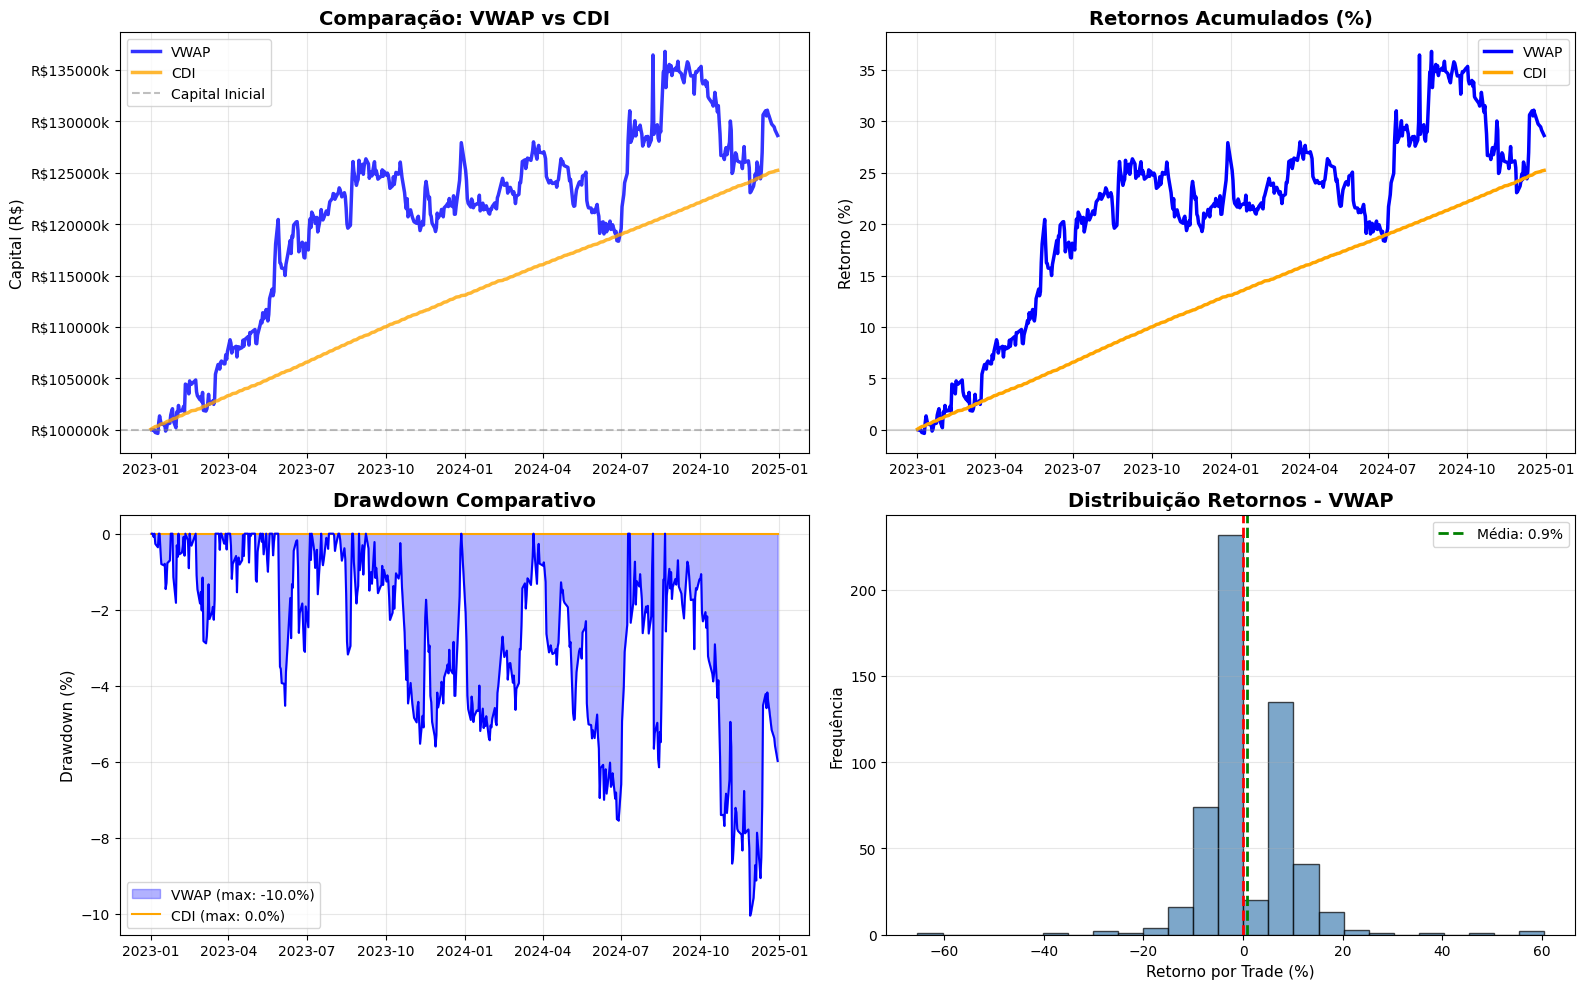

💾 CSVs salvos: vwap_trades.csv, vwap_equity.csv, cdi_equity.csv

✅ ANÁLISE COMPLETA!


In [9]:
# Download
data = download_data()

if data:
    all_dates = sorted(set(d for df in data.values() for d in df.index))

    # VWAP Strategy
    trades_vwap, equity_vwap = backtest_vwap(data, INITIAL_CAPITAL)

    # CDI
    equity_cdi = backtest_cdi(all_dates, INITIAL_CAPITAL)

    # Comparação
    compare_strategies(trades_vwap, equity_vwap, equity_cdi, INITIAL_CAPITAL)

    # Salva
    trades_vwap.to_csv('vwap_trades.csv', index=False)
    equity_vwap.to_csv('vwap_equity.csv', index=False)
    equity_cdi.to_csv('cdi_equity.csv', index=False)
    print("💾 CSVs salvos: vwap_trades.csv, vwap_equity.csv, cdi_equity.csv")

    print("\n✅ ANÁLISE COMPLETA!")
    print("="*70)
else:
    print("\n❌ Sem dados disponíveis!")